<a href="https://colab.research.google.com/github/shlear/MLDM-2022/blob/main/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [14]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [15]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]
    return self.best_feature_ids

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [16]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.8700000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

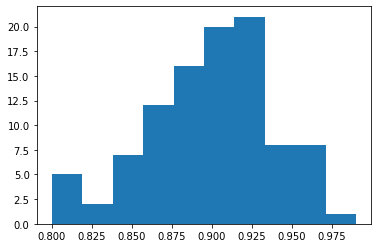

In [17]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

In [18]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)
accuracy = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    best_feature_ids = FeatureSelector(num_features_best).fit(X_train, y_train)
    X_train_best = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
    X_test_best = X_test[:,best_feature_ids]
    
    model = LinearSVC()
    model.fit(X_train_best, y_train)
    
    pred = model.predict(X_test_best)
    accuracy.append(accuracy_score(y_test, pred))
    
mean_accuracy = np.mean(accuracy)
round(mean_accuracy,2)

0.55

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
``` 

In [7]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2023-01-30 12:26:18--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2023-01-30 12:26:18 (5.03 MB/s) - ‘train.csv’ saved [60302/60302]



In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')

In [9]:
# previous code from Data Handling HW
def feature_selection_and_preprocessing(dataset):
    # <YOUR CODE>
    features = dataset.copy()
    features = features[["Pclass","Sex","Age","SibSp","Parch"]]
    features["Age"] = features["Age"].fillna(features["Age"].median())
    features["Sex"].replace({"female": 0,"male": 1}, inplace=True)
    features[["Age","SibSp","Parch"]] = features[["Age","SibSp","Parch"]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return features


model = KNeighborsClassifier(
    # <YOUR CODE>
    n_neighbors=3
)

# Validation code (do not touch)
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Test accuracy: 0.81


In [10]:
parameters = {
        'weights': ['uniform', 'distance'],
        'leaf_size': [i for i in range(20,40)],
        'n_neighbors': [i for i in range(11)],
        'p': [i for i in range(5)]
        }

model4clf = KNeighborsClassifier()
clf = GridSearchCV(model4clf, parameters, scoring='accuracy', n_jobs=-1, verbose=2)

In [11]:
clf.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)


Fitting 5 folds for each of 2200 candidates, totalling 11000 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3000 fits failed out of a total of 11000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py", line 437, in _fit
    self._check_algorithm_metric()
  File "/usr/local/lib/python3.8/dist-packages/sklea

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
                         'n_neighbors': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [0, 1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=2)

In [12]:
knn_best = clf.best_estimator_
test_predictions = knn_best.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)

print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

Test accuracy: 0.81


In [13]:
clf.best_estimator_

KNeighborsClassifier(leaf_size=20, p=4)